WARN: missing folder: data/2016-5 and 2016-6/Batch 3/2016-5/2016-6 P2
BASE_DIRS = ['data/2016-5 and 2016-6/Batch 3/2016-5/2016-5 A2', 'data/2016-5 and 2016-6/Batch 3/2016-5/2016-6 P2']
TOTAL PAIRS = 6
CHOSEN FOLDER = data/2016-5 and 2016-6/Batch 3/2016-5/2016-5 A2
CHOSEN FILES  = Image 5 unannotated.tif | Image 5_FLAT.tif
uint8 8 255
Picked folder: data/2016-5 and 2016-6/Batch 3/2016-5/2016-5 A2
Using: Image 5 unannotated.tif | Image 5_FLAT.tif
Patch (x,y): (1819, 354) mask pixels: 418 CCs: 3
Per-CC choose prob: 0.35 | min_area: 25 | prefer_elongated: True
Elastic alpha/sigma (max): 500 4 | sampled per call
ROI_MARGIN: 8 | PAD: 96


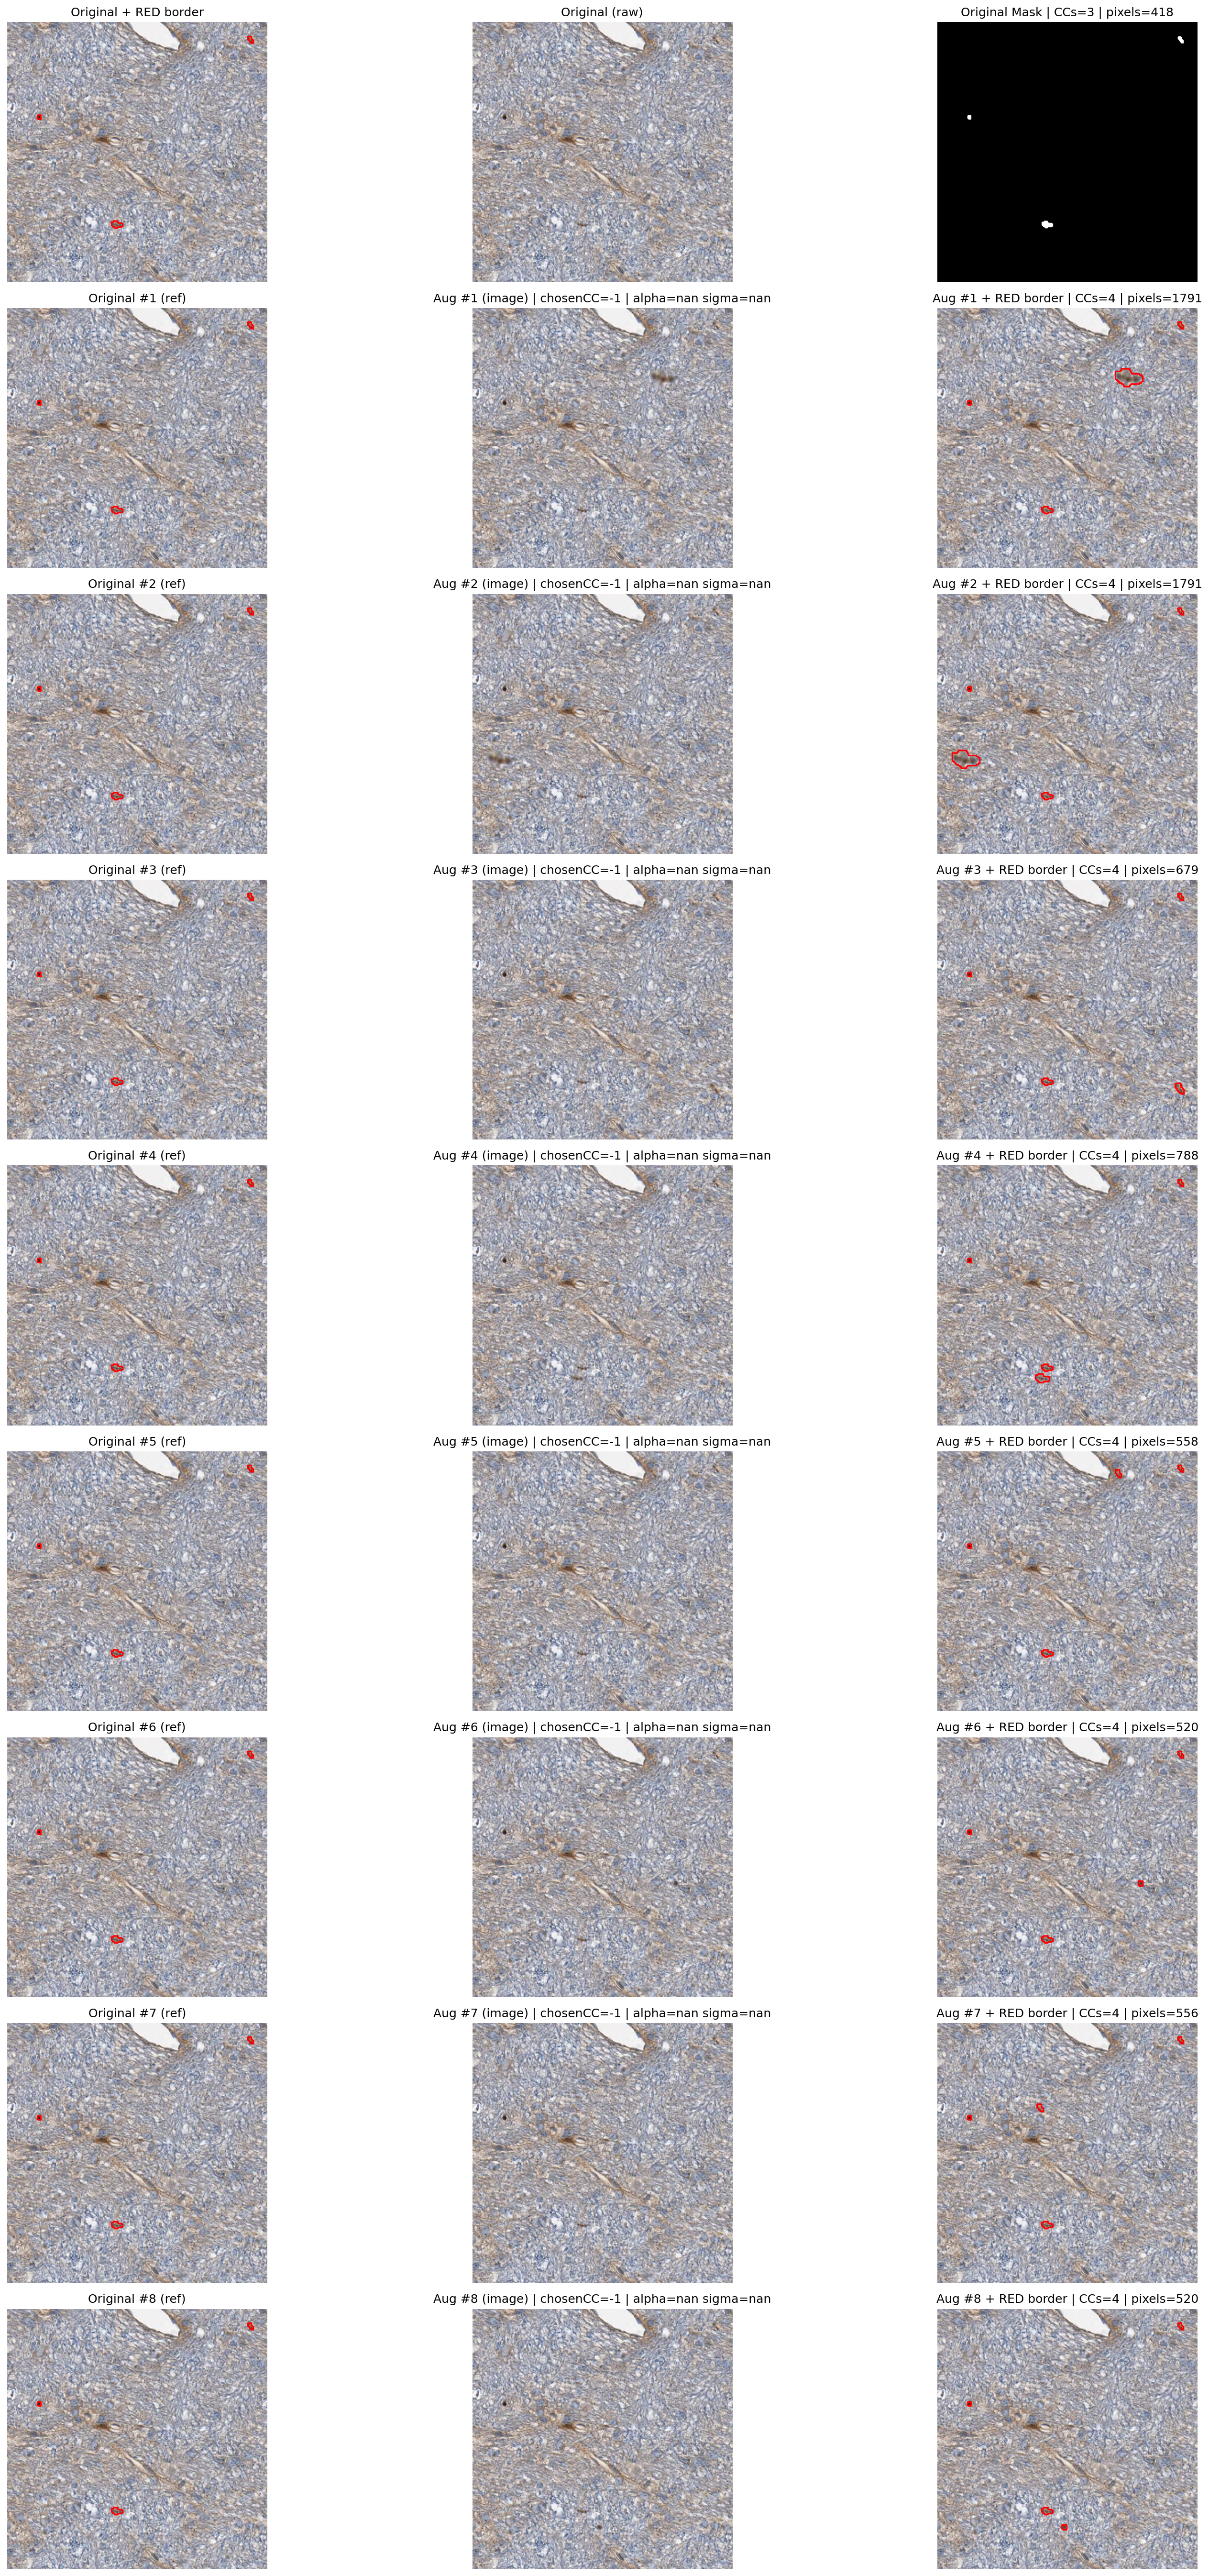

In [13]:
# ONE CELL: Probabilistic per-component ROI warping (NO union bbox rectangles)
# - Supports multiple base folders via BASE_DIRS (randomly picks a folder + image pair each run)
# - Each connected component (CC) is independently chosen with probability P_CHOOSE_CC
# - Each chosen CC gets its OWN tight fitted bbox (+ROI_MARGIN) and is warped locally (image+mask aligned)
# - Big PAD + optional feather blending reduces any ROI seam
# - No global rotate inside ROI. Global rotate/scale are mild.

import os, re, random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tiff
import albumentations as A

# ---------------- GLOBAL CONFIG ----------------
BASE_DIRS_2016 = [
    "data/2016-5 and 2016-6/Batch 3/2016-5/2016-5 A2",
    "data/2016-5 and 2016-6/Batch 3/2016-5/2016-6 P2",
]

BASE_DIRS_2017 = [
    "data/2017-1/Batch 1/",
    "data/2017-1/Batch 2/",
]

BASE_DIRS = BASE_DIRS_2016   # <-- switch here


PATCH = 512
N_AUG = 8
MIN_MASK_PIXELS = 10
SEED = None  # set 0 for reproducible
IGNORE = 255

# --- Probability of choosing EACH component (CC) ---
P_CHOOSE_CC = 0.35     # 0.1 subtle, 0.3-0.4 moderate, 0.6 heavy

# --- CC filtering / preference ---
MIN_CC_AREA = 25       # ignore tiny specks
PREFER_ELONGATED = True  # bias sampling toward long fibers

# --- ROI warp params ---
ROI_MARGIN = 8
PAD = 96
ELASTIC_ALPHA = 500
ELASTIC_SIGMA = 4
ELASTIC_ALPHA_AFFINE = 0  # keep 0 for micro-local realism

# --- Seam handling ---
FEATHER_BLEND = True
FEATHER_WIDTH = 18

if SEED is not None:
    random.seed(SEED)
    np.random.seed(SEED)

import numpy as np
import cv2
import albumentations as A

def component_bbox(labels, lab, margin, H, W):
    ys, xs = np.where(labels == lab)
    if len(ys) == 0:
        return None
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())
    y0 = max(0, y0 - margin); x0 = max(0, x0 - margin)
    y1 = min(H-1, y1 + margin); x1 = min(W-1, x1 + margin)
    return (y0, y1, x0, x1)

def feather_alpha(h, w, feather=18):
    y = np.minimum(np.arange(h), np.arange(h)[::-1]).astype(np.float32)
    x = np.minimum(np.arange(w), np.arange(w)[::-1]).astype(np.float32)
    yy, xx = np.meshgrid(y, x, indexing="ij")
    d = np.minimum(yy, xx)
    a = np.clip(d / max(1, feather), 0, 1)
    return a[..., None]  # (H,W,1)

class ComponentScalePaste(A.DualTransform):
    """
    Extract one connected component (CC), optionally isolate it inside bbox,
    then RESIZE the patch (bigger/smaller) and paste it at a random location.

    - image: paste resized CC patch
    - mask : paste resized CC mask (union)
    """
    def __init__(
        self,
        p_choose=0.7,
        min_cc_area=25,
        margin=8,
        scale_range=(0.8, 1.8),   # >1 makes bigger
        max_scale=None,           # optional hard cap based on image size
        feather_blend=True,
        feather_width=18,
        allow_overlap=True,       # allow pasting on top of other CCs
        require_background=False, # if True, only paste where mask is mostly empty
        bg_max_pixels=10,         # threshold for "mostly empty"
        max_tries=80,
        p=0.5
    ):
        super().__init__(p=p)
        self.p_choose = float(p_choose)
        self.min_cc_area = int(min_cc_area)
        self.margin = int(margin)
        self.scale_range = tuple(map(float, scale_range))
        self.max_scale = float(max_scale) if max_scale is not None else None
        self.feather_blend = bool(feather_blend)
        self.feather_width = int(feather_width)
        self.allow_overlap = bool(allow_overlap)
        self.require_background = bool(require_background)
        self.bg_max_pixels = int(bg_max_pixels)
        self.max_tries = int(max_tries)

    @property
    def targets_as_params(self):
        return ["image", "mask"]

    def __call__(self, force_apply=False, **data):
        if not (force_apply or np.random.rand() < self.p):
            return data

        img = data["image"]
        msk = (data["mask"] > 0).astype(np.uint8)
        H, W = msk.shape

        nlabels, labels = cv2.connectedComponents(msk, connectivity=8)
        if nlabels <= 1 or np.random.rand() > self.p_choose:
            data["_scale_paste_ok"] = 0
            return data

        # eligible CCs (bias to larger a bit)
        labs, areas = [], []
        for lab in range(1, nlabels):
            area = int((labels == lab).sum())
            if area >= self.min_cc_area:
                labs.append(lab)
                areas.append(area)
        if not labs:
            data["_scale_paste_ok"] = 0
            return data

        probs = np.asarray(areas, np.float32)
        probs = probs / probs.sum()
        lab = int(np.random.choice(labs, p=probs))

        bbox = component_bbox(labels, lab, self.margin, H, W)
        if bbox is None:
            data["_scale_paste_ok"] = 0
            return data
        y0, y1, x0, x1 = bbox
        h0, w0 = (y1 - y0 + 1), (x1 - x0 + 1)

        # isolate the CC inside bbox
        cc = (labels[y0:y1+1, x0:x1+1] == lab).astype(np.uint8)
        roi_img = img[y0:y1+1, x0:x1+1].copy()
        roi_msk = cc

        # choose scale (bigger and bigger)
        s = float(np.random.uniform(self.scale_range[0], self.scale_range[1]))
        if self.max_scale is not None:
            s = min(s, self.max_scale)

        h1 = max(2, int(round(h0 * s)))
        w1 = max(2, int(round(w0 * s)))

        # cap to image size
        h1 = min(h1, H)
        w1 = min(w1, W)

        # resize image + mask
        roi_img_r = cv2.resize(roi_img, (w1, h1), interpolation=cv2.INTER_LINEAR)
        roi_msk_r = cv2.resize(roi_msk, (w1, h1), interpolation=cv2.INTER_NEAREST)
        roi_msk_r = (roi_msk_r > 0).astype(np.uint8)

        # build "component-only" patch: keep only CC pixels; rest transparent
        # we'll paste by alpha mask so background shows through
        alpha = roi_msk_r[..., None].astype(np.float32)

        # pick destination anywhere it fits (incl corners)
        dy0 = dx0 = None
        for _ in range(self.max_tries):
            dy0_try = np.random.randint(0, H - h1 + 1)
            dx0_try = np.random.randint(0, W - w1 + 1)

            if self.require_background:
                if int(msk[dy0_try:dy0_try+h1, dx0_try:dx0_try+w1].sum()) > self.bg_max_pixels:
                    continue

            if not self.allow_overlap:
                # disallow overlap with any mask pixels at destination
                if int(msk[dy0_try:dy0_try+h1, dx0_try:dx0_try+w1].sum()) > 0:
                    continue

            dy0, dx0 = dy0_try, dx0_try
            break

        if dy0 is None:
            data["_scale_paste_ok"] = 0
            return data

        dy1, dx1 = dy0 + h1 - 1, dx0 + w1 - 1

        img2 = img.copy()
        msk2 = msk.copy()

        # optional feather on the alpha edge
        if self.feather_blend:
            f = feather_alpha(h1, w1, feather=self.feather_width).astype(np.float32)
            alpha = alpha * f  # soften rectangle boundary (still respects CC mask)

        base = img2[dy0:dy1+1, dx0:dx1+1].astype(np.float32)
        paste = roi_img_r.astype(np.float32)

        img2[dy0:dy1+1, dx0:dx1+1] = np.clip(alpha * paste + (1 - alpha) * base, 0, 255).astype(np.uint8)

        # mask union (pasted CC)
        msk2[dy0:dy1+1, dx0:dx1+1] = np.maximum(msk2[dy0:dy1+1, dx0:dx1+1], roi_msk_r)

        data["image"] = img2
        data["mask"] = msk2
        data["_scale_paste_ok"] = 1
        data["_scale_factor"] = s
        data["_paste_box"] = (dy0, dy1, dx0, dx1)
        return data
    
class ComponentSwapPaste(A.DualTransform):
    """
    Pick ONE connected component, extract its bbox ROI, then SWAP that ROI with a random
    background patch (same size) anywhere in the image (including corners).

    - Image: swaps pixels (optionally feather blends the pasted component)
    - Mask : moves the component mask to the new location; source becomes 0
    """
    def __init__(
        self,
        p_choose=0.35,
        min_cc_area=25,
        margin=8,
        feather_blend=True,
        feather_width=18,
        allow_overlap=False,     # if False, avoid destination overlapping source bbox
        max_tries=50,
        p=0.5
    ):
        super().__init__(p=p)
        self.p_choose = float(p_choose)
        self.min_cc_area = int(min_cc_area)
        self.margin = int(margin)
        self.feather_blend = bool(feather_blend)
        self.feather_width = int(feather_width)
        self.allow_overlap = bool(allow_overlap)
        self.max_tries = int(max_tries)

    @property
    def targets_as_params(self):
        return ["image", "mask"]

    def __call__(self, force_apply=False, **data):
        if not (force_apply or np.random.rand() < self.p):
            return data

        img = data["image"]
        msk = (data["mask"] > 0).astype(np.uint8)
        H, W = msk.shape

        nlabels, labels = cv2.connectedComponents(msk, connectivity=8)
        if nlabels <= 1:
            data["_swap_ok"] = 0
            return data

        # collect eligible CCs
        labs = []
        areas = []
        for lab in range(1, nlabels):
            area = int((labels == lab).sum())
            if area >= self.min_cc_area:
                labs.append(lab)
                areas.append(area)

        if not labs or (np.random.rand() > self.p_choose):
            data["_swap_ok"] = 0
            return data

        # choose one CC (bias to larger a bit)
        areas = np.asarray(areas, np.float32)
        probs = areas / areas.sum()
        lab = int(np.random.choice(labs, p=probs))

        bbox = component_bbox(labels, lab, self.margin, H, W)
        if bbox is None:
            data["_swap_ok"] = 0
            return data

        y0, y1, x0, x1 = bbox
        h = y1 - y0 + 1
        w = x1 - x0 + 1

        # if ROI bigger than image (shouldn't happen, but guard)
        if h <= 1 or w <= 1 or h > H or w > W:
            data["_swap_ok"] = 0
            return data

        # pick destination (anywhere incl corners) where ROI fits
        def overlaps(src, dst):
            (sy0, sy1, sx0, sx1) = src
            (dy0, dy1, dx0, dx1) = dst
            return not (dx1 < sx0 or dx0 > sx1 or dy1 < sy0 or dy0 > sy1)

        src_box = (y0, y1, x0, x1)
        dy0 = dx0 = None

        for _ in range(self.max_tries):
            dy0_try = np.random.randint(0, H - h + 1)
            dx0_try = np.random.randint(0, W - w + 1)
            dst_box = (dy0_try, dy0_try + h - 1, dx0_try, dx0_try + w - 1)

            if self.allow_overlap or (not overlaps(src_box, dst_box)):
                dy0, dx0 = dy0_try, dx0_try
                break

        if dy0 is None:
            data["_swap_ok"] = 0
            return data

        dy1, dx1 = dy0 + h - 1, dx0 + w - 1

        # --- extract patches ---
        src_img = img[y0:y1+1, x0:x1+1].copy()
        src_msk = msk[y0:y1+1, x0:x1+1].copy()

        dst_img = img[dy0:dy1+1, dx0:dx1+1].copy()
        dst_msk = msk[dy0:dy1+1, dx0:dx1+1].copy()

        # we only want to move THIS component's mask (not other stuff in bbox)
        # so isolate that component inside the ROI
        src_cc = (labels[y0:y1+1, x0:x1+1] == lab).astype(np.uint8)

        # build a "component-only" image patch (keep background elsewhere)
        # (this helps if bbox contains other fibers)
        comp_img = src_img.copy()
        comp_img[src_cc == 0] = dst_img[src_cc == 0]  # fill non-CC pixels with destination background

        # --- do swap on IMAGE ---
        img2 = img.copy()

        # put destination background into the source rectangle (pure swap)
        img2[y0:y1+1, x0:x1+1] = dst_img

        # put component patch into destination
        if self.feather_blend:
            a = feather_alpha(h, w, feather=self.feather_width).astype(np.float32)
            base = img2[dy0:dy1+1, dx0:dx1+1].astype(np.float32)
            paste = comp_img.astype(np.float32)
            img2[dy0:dy1+1, dx0:dx1+1] = np.clip(a * paste + (1 - a) * base, 0, 255).astype(np.uint8)
        else:
            img2[dy0:dy1+1, dx0:dx1+1] = comp_img

        # --- do swap on MASK ---
        msk2 = msk.copy()

        # source becomes whatever was at destination (usually background = 0)
        # BUT: we don't want to drag destination's other CCs into the source,
        # so safer: zero out the source box
        msk2[y0:y1+1, x0:x1+1] = 0

        # destination: add the moved CC mask
        # (if you want to overwrite, use '='; if you want union, use max)
        msk2[dy0:dy1+1, dx0:dx1+1] = np.maximum(msk2[dy0:dy1+1, dx0:dx1+1], src_cc)

        data["image"] = img2
        data["mask"] = msk2
        data["_swap_ok"] = 1
        data["_swap_lab"] = lab
        data["_swap_src_box"] = (y0, y1, x0, x1)
        data["_swap_dst_box"] = (dy0, dy1, dx0, dx1)
        return data

    
class PatchGaussianNoise(A.DualTransform):
    """
    Adds Gaussian noise to random rectangular patches.
    Image only (mask unchanged).
    """

    def __init__(
        self,
        num_patches_range=(1, 4),
        patch_size_range=(32, 128),
        noise_std_range=(5, 25),
        p=0.3,
    ):
        super().__init__(p=p)
        self.num_patches_range = num_patches_range
        self.patch_size_range = patch_size_range
        self.noise_std_range = noise_std_range

    def apply(self, image, **params):
        img = image.astype(np.float32)

        H, W = img.shape[:2]
        n_patches = np.random.randint(
            self.num_patches_range[0],
            self.num_patches_range[1] + 1
        )

        for _ in range(n_patches):

            ph = np.random.randint(*self.patch_size_range)
            pw = np.random.randint(*self.patch_size_range)

            y = np.random.randint(0, max(1, H - ph))
            x = np.random.randint(0, max(1, W - pw))

            std = np.random.uniform(*self.noise_std_range)

            noise = np.random.normal(
                0, std, size=(ph, pw, 3)
            ).astype(np.float32)

            img[y:y+ph, x:x+pw] += noise

        return np.clip(img, 0, 255).astype(np.uint8)

    def apply_to_mask(self, mask, **params):
        return mask

# ---------------- IO HELPERS ----------------
import os, re

def list_pairs(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith((".tif", ".tiff"))]

    unann, ann = {}, {}

    for f in files:
        f_stripped = f.strip()

        # --- unannotated ---
        m1 = re.match(r"^image\s*(\d+)\s*unannotated\.tif(f)?$", f_stripped, flags=re.IGNORECASE)
        if m1:
            unann[int(m1.group(1))] = os.path.join(folder, f)
            continue

        # --- annotated variants ---
        # 2016 style: "Image 6_FLAT.tif" or "Image 6 _FLAT.tif"
        m2a = re.match(r"^image\s*(\d+)\s*_?flat\.tif(f)?$", f_stripped, flags=re.IGNORECASE)

        # 2017 style: "IMAGE 13 annotated_FLAT.tif" or "IMAGE 13_annotated_FLAT.tif"
        m2b = re.match(r"^image\s*(\d+)\s*_?annotated_?flat\.tif(f)?$", f_stripped, flags=re.IGNORECASE)

        if m2a:
            ann[int(m2a.group(1))] = os.path.join(folder, f)
            continue
        if m2b:
            ann[int(m2b.group(1))] = os.path.join(folder, f)
            continue

    keys = sorted(set(unann.keys()) & set(ann.keys()))
    return [(k, unann[k], ann[k]) for k in keys]


def list_pairs_multi(folders):
    all_pairs = []
    for fd in folders:
        if not os.path.isdir(fd):
            print("WARN: missing folder:", fd)
            continue
        pairs = list_pairs(fd)
        if len(pairs) == 0:
            print("WARN: no pairs found in:", fd)
        all_pairs.extend(pairs)
    return all_pairs

def read_tif_rgb(path):
    img = tiff.imread(path)
    if img.ndim == 3 and img.shape[0] in (3, 4) and img.shape[-1] not in (3, 4):
        img = np.transpose(img, (1, 2, 0))
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[-1] == 4:
        img = img[..., :3]
    if img.dtype != np.uint8:
        imin, imax = float(img.min()), float(img.max())
        if imax > imin:
            img = (255.0 * (img - imin) / (imax - imin)).astype(np.uint8)
        else:
            img = np.zeros_like(img, dtype=np.uint8)
    return img

def green_mask_from_annotated_rgb(ann_rgb):
    hsv = cv2.cvtColor(ann_rgb, cv2.COLOR_RGB2HSV)
    lower = np.array([35, 120, 60], dtype=np.uint8)
    upper = np.array([85, 255, 255], dtype=np.uint8)
    m = cv2.inRange(hsv, lower, upper)
    m = cv2.medianBlur(m, 5)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)
    m = cv2.dilate(m, np.ones((3, 3), np.uint8), iterations=1)
    return (m > 0).astype(np.uint8)

def draw_border(rgb, msk, color=(255, 0, 0), thickness=2, black_thr=8):
    """
    Draw GT border, but DO NOT draw inside CoarseDropout holes (black squares).
    Also ignores IGNORE=255 if present in mask.
    """
    out = rgb.copy()

    # 1) binary mask to contour
    m = (msk > 0).astype(np.uint8)

    # If your mask ever contains IGNORE=255, remove it from contours
    # (safe even if it doesn't)
    m[(msk == IGNORE)] = 0

    # 2) detect dropout holes in the IMAGE (near-black)
    holes = (rgb[..., 0] < black_thr) & (rgb[..., 1] < black_thr) & (rgb[..., 2] < black_thr)

    # 3) do not contour where holes exist
    m[holes] = 0

    cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        cv2.drawContours(out, cnts, -1, color, thickness)
    return out


def cc_count(binary_mask):
    nlabels, _ = cv2.connectedComponents((binary_mask > 0).astype(np.uint8), connectivity=8)
    return nlabels - 1

def feather_alpha(h, w, feather=18):
    y = np.minimum(np.arange(h), np.arange(h)[::-1]).astype(np.float32)
    x = np.minimum(np.arange(w), np.arange(w)[::-1]).astype(np.float32)
    yy, xx = np.meshgrid(y, x, indexing="ij")
    d = np.minimum(yy, xx)
    a = np.clip(d / max(1, feather), 0, 1)
    return a[..., None]  # (H,W,1)

def component_bbox(labels, lab, margin, H, W):
    ys, xs = np.where(labels == lab)
    if len(ys) == 0:
        return None
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())
    y0 = max(0, y0 - margin); x0 = max(0, x0 - margin)
    y1 = min(H-1, y1 + margin); x1 = min(W-1, x1 + margin)
    return (y0, y1, x0, x1)

def sample_components(labels, min_area=25, p_choose=0.35, prefer_elongated=True, max_pick=None):
    """
    Returns list of CC labels chosen.
    If prefer_elongated=True, we do weighted Bernoulli (elongated CCs more likely).
    """
    nlabels = int(labels.max()) + 1
    if nlabels <= 1:
        return []

    labs = []
    weights = []
    for lab in range(1, nlabels):
        ys, xs = np.where(labels == lab)
        area = len(ys)
        if area < min_area:
            continue
        labs.append(lab)

        if prefer_elongated:
            h = (ys.max() - ys.min() + 1)
            w = (xs.max() - xs.min() + 1)
            elong = max(h, w) / max(1, min(h, w))  # aspect ratio
            weights.append(float(elong))
        else:
            weights.append(1.0)

    if not labs:
        return []

    weights = np.array(weights, dtype=np.float32)
    weights = weights / weights.sum()

    chosen = []
    for lab, w in zip(labs, weights):
        # weighted probability: base p_choose scaled by normalized elongation weight
        p = float(np.clip(p_choose * (w / weights.mean()), 0.0, 1.0)) if prefer_elongated else float(p_choose)
        if np.random.rand() < p:
            chosen.append(lab)

    if max_pick is not None and len(chosen) > max_pick:
        chosen = list(np.random.choice(chosen, size=max_pick, replace=False))

    return chosen

# ---------------- Per-Component ROI Warp Transform ----------------
class ProbabilisticComponentWarp(A.DualTransform):
    """
    For each CC chosen with probability p_choose, warp its fitted bbox locally.
    """
    def __init__(
        self,
        p_choose=0.35,
        min_cc_area=25,
        prefer_elongated=True,
        margin=8,
        pad=96,
        elastic_alpha=900,
        elastic_sigma=4,
        alpha_affine=0,
        feather_blend=True,
        feather_width=18,
        max_pick=8,     # safety: cap number of CCs warped per patch
        p=1.0
    ):
        super().__init__(p=p)
        self.p_choose = float(p_choose)
        self.min_cc_area = int(min_cc_area)
        self.prefer_elongated = bool(prefer_elongated)
        self.margin = int(margin)
        self.pad = int(pad)
        self.feather_blend = bool(feather_blend)
        self.feather_width = int(feather_width)
        self.max_pick = int(max_pick) if max_pick is not None else None

        # Randomize elastic strength PER CALL (so every augmentation is different)
        self.elastic_alpha_range = (200.0, float(elastic_alpha))
        self.elastic_sigma_range = (3.0, float(elastic_sigma))
        self.alpha_affine = float(alpha_affine)

    @property
    def targets_as_params(self):
        return ["image", "mask"]

    def __call__(self, force_apply=False, **data):
        if not (force_apply or np.random.rand() < self.p):
            return data

        # Sample elastic params per augmentation call
        alpha = float(np.random.uniform(*self.elastic_alpha_range))
        sigma = float(np.random.uniform(*self.elastic_sigma_range))

        img = data["image"]
        mask = (data["mask"] > 0).astype(np.uint8)
        H, W = mask.shape

        nlabels, labels = cv2.connectedComponents(mask, connectivity=8)
        if nlabels <= 1:
            return data

        chosen_labs = sample_components(
            labels,
            min_area=self.min_cc_area,
            p_choose=self.p_choose,
            prefer_elongated=self.prefer_elongated,
            max_pick=self.max_pick
        )

        if len(chosen_labs) == 0:
            data["_chosen_cc_count"] = 0
            return data

        img2 = img.copy()
        mask2 = mask.copy()

        # Make ROI augmenter with sampled params (fresh each call)
        roi_aug = A.Compose([
            A.ElasticTransform(
                alpha=alpha,
                sigma=sigma,
                interpolation=cv2.INTER_LINEAR,
                mask_interpolation=cv2.INTER_NEAREST,
                border_mode=cv2.BORDER_REFLECT_101,
                p=1.0,
            )
        ])

        # warp each chosen CC in its OWN ROI (no union bbox)
        for lab in chosen_labs:
            bbox = component_bbox(labels, lab, self.margin, H, W)
            if bbox is None:
                continue
            y0, y1, x0, x1 = bbox

            img_roi = img2[y0:y1+1, x0:x1+1].copy()
            msk_roi = mask2[y0:y1+1, x0:x1+1].copy()

            H0, W0 = msk_roi.shape[:2]
            PAD = self.pad

            img_pad = cv2.copyMakeBorder(img_roi, PAD, PAD, PAD, PAD, borderType=cv2.BORDER_REFLECT_101)
            msk_pad = cv2.copyMakeBorder(msk_roi, PAD, PAD, PAD, PAD, borderType=cv2.BORDER_CONSTANT, value=0)

            out = roi_aug(image=img_pad, mask=msk_pad)
            img_w = out["image"][PAD:PAD+H0, PAD:PAD+W0]
            msk_w = (out["mask"][PAD:PAD+H0, PAD:PAD+W0] > 0).astype(np.uint8)

            if self.feather_blend:
                a = feather_alpha(H0, W0, feather=self.feather_width).astype(np.float32)
                base = img2[y0:y1+1, x0:x1+1].astype(np.float32)
                img2[y0:y1+1, x0:x1+1] = np.clip(a*img_w.astype(np.float32) + (1-a)*base, 0, 255).astype(np.uint8)
            else:
                img2[y0:y1+1, x0:x1+1] = img_w

            mask2[y0:y1+1, x0:x1+1] = msk_w

        data["image"] = img2
        data["mask"]  = mask2
        data["_chosen_cc_count"] = len(chosen_labs)
        data["_elastic_alpha"] = alpha
        data["_elastic_sigma"] = sigma
        return data

# ---------------- TRAIN AUG ----------------
train_aug = A.Compose([
    # Geometry (safe)
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.2),
    # A.RandomRotate90(p=0.3),
    # A.RGBShift(r_shift_limit=18, g_shift_limit=12, b_shift_limit=18, p=0.6),
    # A.Affine(
    #     translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
    #     scale=(0.50, 1.50),
    #     rotate=(-40, 40),
    #     interpolation=cv2.INTER_LINEAR,
    #     mask_interpolation=cv2.INTER_NEAREST,
    #     mode=cv2.BORDER_REFLECT_101,
    #     p=0.5
    # ),

    ComponentScalePaste(
        p_choose=0.9,
        min_cc_area=MIN_CC_AREA,
        margin=ROI_MARGIN,
        scale_range=(1.0, 2.5),     # bigger and bigger
        feather_blend=True,
        feather_width=18,
        require_background=False,   # set True if you want only empty areas
        p=0.99
    ),
    
    # ComponentSwapPaste(
    #     p_choose=0.4,        # chance to attempt choosing a CC
    #     min_cc_area=MIN_CC_AREA,
    #     margin=ROI_MARGIN,
    #     feather_blend=True,
    #     feather_width=18,
    #     allow_overlap=False,
    #     p=0.9
    # ),
    

    # Acquisition realism (one-of)
#     A.OneOf([
#         A.RandomBrightnessContrast(0.10, 0.10),
#         A.ColorJitter(brightness=0.08, contrast=0.08, saturation=0.06, hue=0.02),
#         A.GaussianBlur(blur_limit=(3, 5)),
#         A.MotionBlur(blur_limit=3),
#         A.ISONoise(color_shift=(0.01, 0.2), intensity=(0.1, 0.35)),
#         A.ImageCompression(quality_lower=60, quality_upper=95),
#     ], p=0.6),
    
#     PatchGaussianNoise(
#         num_patches_range=(1, 3),
#         patch_size_range=(48, 160),
#         noise_std_range=(8, 30),
#         p=0.4
#     ),

#     # Your local per-CC warp (keep, but not insane)
    ProbabilisticComponentWarp(
        p_choose=0.25,          # consider lowering from 0.35
        min_cc_area=MIN_CC_AREA,
        prefer_elongated=True,
        margin=ROI_MARGIN,
        pad=PAD,
        elastic_alpha=600,
        elastic_sigma=8,
        alpha_affine=0,
        feather_blend=True,
        feather_width=18,
        max_pick=6,
        p=0.1,                  # not always
    ),
])


# ---------------- PICK IMAGE PAIR + PATCH ----------------
pairs = list_pairs_multi(BASE_DIRS)
print("BASE_DIRS =", BASE_DIRS)
print("TOTAL PAIRS =", len(pairs))

idx, unann_path, ann_path = random.choice(pairs)
print("CHOSEN FOLDER =", os.path.dirname(unann_path))
print("CHOSEN FILES  =", os.path.basename(unann_path), "|", os.path.basename(ann_path))


# pairs = list_pairs_multi(BASE_DIRS)
assert len(pairs) > 0, "No TIFF pairs found. Check BASE_DIRS and filenames."

idx, unann_path, ann_path = random.choice(pairs)
unann = read_tif_rgb(unann_path)
ann   = read_tif_rgb(ann_path)
mask_full = green_mask_from_annotated_rgb(ann)

if ann.shape[:2] != unann.shape[:2]:
    ann = cv2.resize(ann, (unann.shape[1], unann.shape[0]), interpolation=cv2.INTER_LINEAR)
    mask_full = cv2.resize(mask_full, (unann.shape[1], unann.shape[0]), interpolation=cv2.INTER_NEAREST)

H, W = unann.shape[:2]
if H < PATCH or W < PATCH:
    raise ValueError(f"Image too small for {PATCH} patch: {(H, W)}")

chosen = None
for _ in range(120):
    x = random.randint(0, W - PATCH)
    y = random.randint(0, H - PATCH)
    if int(mask_full[y:y+PATCH, x:x+PATCH].sum()) > MIN_MASK_PIXELS:
        chosen = (x, y)
        break
if chosen is None:
    x = random.randint(0, W - PATCH)
    y = random.randint(0, H - PATCH)

img = unann[y:y+PATCH, x:x+PATCH].copy()
msk = mask_full[y:y+PATCH, x:x+PATCH].copy().astype(np.uint8)

print(img.dtype, img.min(), img.max())
print("Picked folder:", os.path.dirname(unann_path))
print("Using:", os.path.basename(unann_path), "|", os.path.basename(ann_path))
print("Patch (x,y):", (x, y), "mask pixels:", int(msk.sum()), "CCs:", cc_count(msk))
print("Per-CC choose prob:", P_CHOOSE_CC, "| min_area:", MIN_CC_AREA, "| prefer_elongated:", PREFER_ELONGATED)
print("Elastic alpha/sigma (max):", ELASTIC_ALPHA, ELASTIC_SIGMA, "| sampled per call")
print("ROI_MARGIN:", ROI_MARGIN, "| PAD:", PAD)

# ---------------- VISUALIZATION ----------------
rows = 1 + N_AUG
cols = 3
plt.figure(figsize=(22, 4*rows), dpi=150)

plt.subplot(rows, cols, 1)
plt.imshow(draw_border(img, msk, color=(255, 0, 0), thickness=2))
plt.title("Original + RED border")
plt.axis("off")

plt.subplot(rows, cols, 2)
plt.imshow(img)
plt.title("Original (raw)")
plt.axis("off")

plt.subplot(rows, cols, 3)
plt.imshow(msk, cmap="gray")
plt.title(f"Original Mask | CCs={cc_count(msk)} | pixels={int(msk.sum())}")
plt.axis("off")

for i in range(N_AUG):
    out = train_aug(image=img, mask=msk)
    aug_img = out["image"]
    aug_msk = ((out["mask"] > 0) & (out["mask"] != IGNORE)).astype(np.uint8)

    
    chosen_ct = int(out.get("_chosen_cc_count", -1))
    a = float(out.get("_elastic_alpha", float("nan")))
    s = float(out.get("_elastic_sigma", float("nan")))

    plt.subplot(rows, cols, 3*(i+1)+1)
    plt.imshow(draw_border(img, msk, color=(255, 0, 0), thickness=2))
    plt.title(f"Original #{i+1} (ref)")
    plt.axis("off")

    plt.subplot(rows, cols, 3*(i+1)+2)
    plt.imshow(aug_img)
    plt.title(f"Aug #{i+1} (image) | chosenCC={chosen_ct} | alpha={a:.1f} sigma={s:.1f}")
    plt.axis("off")

    plt.subplot(rows, cols, 3*(i+1)+3)
    plt.imshow(draw_border(aug_img, aug_msk, color=(255, 0, 0), thickness=2))
    plt.title(f"Aug #{i+1} + RED border | CCs={cc_count(aug_msk)} | pixels={int(aug_msk.sum())}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Test